## Supervised Learning Final Project

### Kaggle Titanic Competition

### Author: Samuel Greene

This project attempts to predict whether certain people aboard the Titanic survived the journey. For more information see: https://www.kaggle.com/competitions/titanic/overview

In [244]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

### Importing Data

First I will import the train and test CSV files into a dataframe. We see below all of the features and notice that several have null values. 

In [245]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [247]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Features

* PassengerId = a numeric identifier assigned to each passenger
* Survived = the target where a 1 indicates survival and 0 indicates otherwise
* Pclass = the class of ticket 1st, 2nd or 3rd
* Name = passenger name
* Sex = Male/Female
* Age = passenger age
* SibSp = # of siblings or spouses onboard that the passenger has
* Parch = # of parents or children onboard the passenger has
* Ticket = alphanumeric ticket number
* Fare = cost of ticket
* Cabin = which part of the ship the passenger was on
* Embarked = where the passenger boarded the ship

### Filling Null Values and Feature Engineering

Below I impute missing values for entries with Nulls


**Embarked**

Since there are only two missing values in the train data set we will attempt to impute them manually by looking at the names.

In [248]:
print(df.loc[[61,829],:])
df['Embarked'].value_counts()

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Since the first name appears to be French we will assign C for Cherbourgh. The second name is less obvious so we will assign S since it occurs most frequently.

In [249]:
df.at[61, "Embarked"] = "C" 
df.at[829, "Embarked"] = "S" 

**Fare**

We have only one missing value for Fare so we will just replace with the mean.

In [250]:
df['Fare'].fillna(np.mean(df['Fare']), inplace=True)
test_df['Fare'].fillna(np.mean(df['Fare']), inplace=True)

**Cabin**

Since there are many mising values for Cabin we will not attempt to impute missing values. Instead a value of unknown is added if Cabin is null. We also seek to extract only the letter of the Cabin and ignore the numbers.

In [251]:
df['Cabin'].fillna(value = 'unknown', inplace=True)
test_df['Cabin'].fillna(value='unknown', inplace=True)

def cabin(cab, letters):
    for letter in letters:
        if letter in cab:
            return letter
    return None

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

df['Cabin'] = df['Cabin'].map(lambda x: cabin(x, letters))
test_df['Cabin'] = test_df['Cabin'].map(lambda x: cabin(x, letters))

**Age and Title Feature Extraction**

Below we impute the missing age values, but before we will extract titles from an individuals name to help. The most common titles were Mr, Master, Mrs, and Miss. There were many other titles, but they occured very infrequently. Below I classify everyone into one of the four most common titles by age. 

In [252]:
def title(name, titles):
    for title in titles:
        if title in name:
            return title
    return None

title_list = ['Mrs', 'Mr', 'Miss', 'Master']

df['Title'] = df['Name'].map(lambda x: title(x, title_list))
test_df['Title'] = test_df['Name'].map(lambda x: title(x, title_list))

def impute_Nones(x):
    if pd.isnull(x['Title']):
        if x['Sex'] == 'male':
            if x['Age'] <= 12:
                return 'Master'
            else:
                return 'Mr'
        elif x['Sex'] == 'female':
            if x['Age'] >= 23:
                return 'Mrs'
            else:
                return 'Miss'
    else:
        return x['Title']

df['Title'] = df.apply(impute_Nones, axis=1)
test_df['Title'] = df.apply(impute_Nones, axis=1)


df['Title'].value_counts()

Mr        537
Miss      180
Mrs       134
Master     40
Name: Title, dtype: int64

**Imputing Age**

Now that everyone has a title we will calculate the mean age of each title and use that to impute missing values.

In [253]:
mrs = df.loc[df['Title'] == 'Mrs']
mrs_mean_age = np.mean(mrs['Age'])

mr = df.loc[df['Title'] == 'Mr']
mr_mean_age = np.mean(mr['Age'])

miss = df.loc[df['Title'] == 'Miss']
miss_mean_age = np.mean(miss['Age'])

master = df.loc[df['Title'] == 'Master']
master_mean_age = np.mean(master['Age'])

print('mrs_mean_age:', mrs_mean_age)
print('mr_mean_age:', mr_mean_age)
print('miss_mean_age:', miss_mean_age)
print('master_mean_age:', master_mean_age)


mrs_mean_age: 35.47008547008547
mr_mean_age: 32.98441247002398
miss_mean_age: 21.77777777777778
master_mean_age: 4.574166666666667


In [254]:
def impute_ages(x):
    if pd.isnull(x['Age']):
        if x['Title'] == 'Mrs':
            return 35
        elif x['Title'] == 'Master':
            return 4.5
        elif x['Title'] == 'Miss':
            return 22
        else:
            return 33
    else:
        return x['Age']

df['Age'] = df.apply(impute_ages, axis=1)
test_df['Age'] = df.apply(impute_ages, axis=1)

In [255]:
def get_family_size(x):
    family_size = x['SibSp'] + x['Parch']
    return family_size

df['FamilySize'] = df.apply(get_family_size, axis=1)
test_df['FamilySize'] = df.apply(get_family_size, axis=1)

**Fare**
We see that Fare is quite skewed so I take the log

<AxesSubplot:>

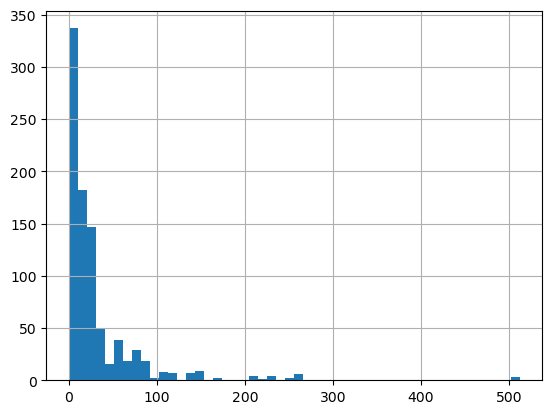

In [256]:
df['Fare'].hist(bins = 50)

<AxesSubplot:>

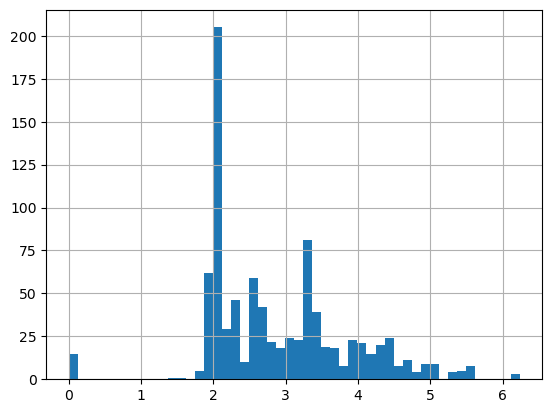

In [257]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
test_df['Fare'] = test_df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
df['Fare'].hist(bins = 50)

### Encoding Features

Below we enocode the features to numeric so that they can be fed to the models. The Title column will later be dropped which is discussed below so it will not be encoded.

In [258]:
df = pd.get_dummies(df, columns = ['Embarked', 'Cabin'])
test_df = pd.get_dummies(test_df, columns = ['Embarked', 'Cabin'])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,...,0,0,1,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,...,1,0,0,0,0,1,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,...,0,0,1,0,0,1,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,...,0,0,1,0,0,0,0,0,0,0


In [259]:
encoder = preprocessing.LabelEncoder()

features = ['Sex']
for feature in features:
    df[feature] = encoder.fit_transform(df[feature])
    test_df[feature] = encoder.fit_transform(test_df[feature])

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Title,...,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,892,3,"Kelly, Mr. James",1,22.0,0,0,330911,2.057860,Mr,...,0,1,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,38.0,1,0,363272,1.945910,Mrs,...,0,0,1,0,0,0,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,26.0,0,0,240276,2.270836,Miss,...,0,1,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",1,35.0,0,0,315154,2.159003,Mrs,...,0,0,1,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,35.0,1,1,3101298,2.508582,Mr,...,0,0,1,0,0,0,0,0,0,0


In [261]:
#make test and train data
y = df['Survived']
X = df.drop(['Survived', 'PassengerId', 'Ticket', 'Name', 'Title'], axis=1)

X_submission = test_df.drop(['PassengerId', 'Ticket', 'Name', 'Title'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    int32  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   FamilySize  891 non-null    int64  
 7   Embarked_C  891 non-null    uint8  
 8   Embarked_Q  891 non-null    uint8  
 9   Embarked_S  891 non-null    uint8  
 10  Cabin_A     891 non-null    uint8  
 11  Cabin_B     891 non-null    uint8  
 12  Cabin_C     891 non-null    uint8  
 13  Cabin_D     891 non-null    uint8  
 14  Cabin_E     891 non-null    uint8  
 15  Cabin_F     891 non-null    uint8  
 16  Cabin_G     891 non-null    uint8  
dtypes: float64(2), int32(1), int64(4), uint8(10)
memory usage: 54.1 KB


### Creating Models
Here I have chose 5 different models to evaluate: 
* Gradient Boost Classifier
* Logistic Regression
* Random Forest
* KNN
* SVM

Below all of the models are fit with the training data and a crossvalidation score is assigned with 10 folds. Several of the models with hyperparameters are tuned using an exhaustive grid search. 

**Gradient Boosting Classifier**

In [145]:
grid_size = 5
n_estimators = (np.linspace(10,200,grid_size,dtype=int))
learning_rates = np.logspace(start=-2, stop=1,num=grid_size)
max_depth = np.arange(1,3)
parameters = {'n_estimators':n_estimators,'max_depth':max_depth, 'learning_rate':learning_rates}

grid = GridSearchCV(GradientBoostingClassifier(random_state=0), parameters, refit=True, cv=5)
clf = grid.fit(x_train,y_train)
grid.best_params_

{'learning_rate': 0.05623413251903491, 'max_depth': 2, 'n_estimators': 200}

In [262]:
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=2,ccp_alpha=0.0015, random_state=0).fit(X,y)
gb_cv = np.mean(cross_val_score(gb_clf, X, y, cv=10))

**Logstic Regression**

In [263]:
lr_clf = LogisticRegression(max_iter=1000).fit(x_train, y_train)
lr_cv = np.mean(cross_val_score(lr_clf, X, y, cv=10))

**Random Forest**

In [243]:
grid_size = 20
ccp_alpha = np.logspace(start=-3, stop=1,num=grid_size)
max_depth = np.arange(1,4)
parameters = {'ccp_alpha':ccp_alpha, 'max_depth':max_depth}

grid = GridSearchCV(RandomForestClassifier(n_estimators=200,random_state=0), parameters, refit=True, cv=10)
clf = grid.fit(X,y)
grid.best_params_

{'ccp_alpha': 0.001623776739188721, 'max_depth': 3}

In [264]:
rf_clf = RandomForestClassifier(n_estimators = 200, max_depth=4, max_features='sqrt', ccp_alpha=0.0015, random_state=0).fit(X, y)
rf_cv = np.mean(cross_val_score(rf_clf, X, y, cv=10))

**KNN**

In [265]:
knn_clf = KNeighborsClassifier(n_neighbors = 5).fit(X,y)
knn_cv = np.mean(cross_val_score(knn_clf, X, y, cv=10))

**SVM**

In [102]:
grid_size = 20

C = np.logspace(start=-5, stop=5, num=grid_size, base=2)
gamma = np.logspace(start=-5, stop=5, num=grid_size, base=2)
parameters = {'C':C, 'gamma':gamma}

grid = GridSearchCV(SVC(kernel='rbf'), parameters, refit=True,cv=10)
clf = grid.fit(X,y)
grid.best_params_

{'C': 2.489385178928047, 'gamma': 0.06482219027788699}

In [266]:
svm_clf = SVC(kernel='rbf', C=2.5, gamma=0.05).fit(X,y)
svm_cv = np.mean(cross_val_score(svm_clf, X,y,cv=10))

**Cross Validation Scores**

Here we compare the cross validation scores of each classifier after some parameter tuning

In [267]:
models = pd.DataFrame({'Model': ['Gradient Boost', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM'],
                      '10_Fold_CV_Score': [gb_cv, lr_cv, rf_cv, knn_cv, svm_cv]})
models.sort_values(by='10_Fold_CV_Score', ascending=False)

,Model,10_Fold_CV_Score
0,Gradient Boost,0.824919
2,Random Forest,0.822684
4,SVM,0.818202
1,Logistic Regression,0.791286
3,KNN,0.774457


### Model Evaluation

**Metrics** 

We have already used crossvalidation above to compare the models, but below we do a split on the train data to evaluate other parameters. We must split because the test data for submission does not have labels. The below function calculates the following for the top classifer:
* Accuracy
* F1 Score
* ROC Curve
* Area under ROC curve
* Confusion Matrix

In [268]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [269]:
def evaluate_model(model, x_test, y_test, estimator_name):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()
    print('Accuracy Score:', accuracy_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))
    print('roc_auc_score:', roc_auc_score(y_test, y_pred, average='weighted'))
    ypp = model.predict_proba(x_test)
    fpr, tpr, th = roc_curve(y_test, ypp[:,1], pos_label=clf.classes_[1])
    roc_auc = roc_auc_score(y_test, y_pred, average='weighted')
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=estimator_name).plot()

**Random Forest Metrics**

Gradient Boost Metrics
Accuracy Score: 0.8100558659217877
F1 Score: 0.746268656716418
roc_auc_score: 0.7991418610887637


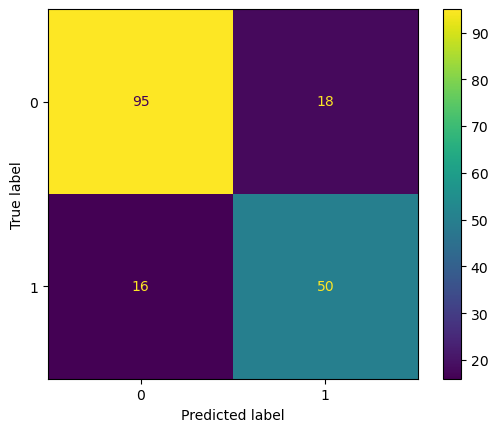

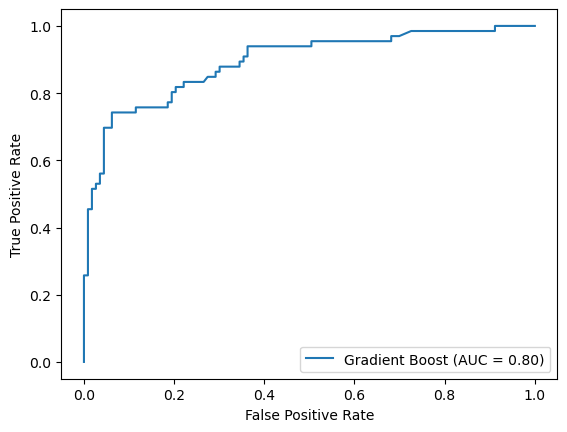

In [270]:
print('Gradient Boost Metrics')
estimator_name = 'Gradient Boost' 
rf_clf_metrics = rf_clf.fit(x_train, y_train)
evaluate_model(rf_clf, x_test, y_test, estimator_name)

### Ensembling Models

Below I create a voting ensemble with the classifiers generated above. 

In [271]:
weights = [1, 1, 1, 1]
ens_clf = VotingClassifier(estimators=[
            ('GB',gb_clf), ('lr', lr_clf), ('rf', rf_clf), ('svm', svm_clf)],
            voting='hard', weights=weights).fit(X,y)
ens_cv = np.mean(cross_val_score(svm_clf, X,y,cv=10))
print('Ensemble CV score:', ens_cv)

Ensemble CV score: 0.8182022471910113


We see that the cross validation score is competitive with the other high performing models, but the Random Forest base model still scores higher.

## Results
I submitted the ensemble, random forest, and gradient boost models to kaggle. Despite the gradient boost model performing best with cross validation it actually scored lower than the random forest and the hard voting ensemble. The final scores were. Tweaking the features and dropping some can result in slight variations, so the scores below may vary slightly from the using all of the features.

Perhaps most interesting to me was the fact that dropping the titles vastly improved accuracy score on submission despite decreasing the model accuracy with the metrics calculated above. My best guess is that somehow the models were overfit or the test data looked different somehow to the training data. 

* Voting Ensemble: 79.18%
* Random Forest:   77.99%
* Gradient Boost:  74.88%

### Kaggle Submission

Below I generate the submission CSV to submit to the kaggle challenge

In [275]:
submission_predictions = ens_clf.predict(X_submission)
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':submission_predictions})
submission.to_csv('submission.csv', index=False)